In [101]:
with open('configs/vote-config.py', 'w') as fp:
  fp.write("""# The new config inherits a base config to highlight the necessary modification
_base_ = 'mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py'

# We also need to change the num_classes in head to match the dataset's annotation
model = dict(
    roi_head=dict(
        bbox_head=dict(num_classes=1), mask_head=dict(num_classes=1)))

# Modify dataset related settings
data_root = 'data/table-det-elect66/'
metainfo = {
    'classes': ('Table', ),
    'palette': [
        (220, 20, 60),
    ]
}
train_dataloader = dict(
    batch_size=8,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        ann_file='result.json',
        data_prefix=dict(img='')
    )
)
val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        ann_file='result.json',
        data_prefix=dict(img='')
    )
)
test_dataloader = val_dataloader

# Modify metric related settings
val_evaluator = dict(ann_file=data_root + 'result.json')
test_evaluator = val_evaluator

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=70, val_interval=5)
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001))
default_hooks = dict(
    checkpoint=dict(type='CheckpointHook', interval=5))

# We can use the pre-trained Mask RCNN model to obtain higher performance
load_from = 'https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
""")

In [10]:
from mmdet.apis import init_detector, inference_detector
import mmcv
import os
from PIL import Image, ImageDraw

In [11]:
def resize_image(pil_image, max_size=1280):
    """
    Resizes an image to 1280 width or height, whichever is larger.
    And keeps the aspect ratio.
    """
    width, height = pil_image.size
    if width > height:
        new_width = max_size
        new_height = int(new_width * height / width)
    else:
        new_height = max_size
        new_width = int(new_height * width / height)
    return pil_image.resize((new_width, new_height))

In [79]:
image_path = '4068895865148128137.jpg'

In [117]:
config_file = 'work_dirs/vote-config/vote-config.py'
checkpoint_file = 'work_dirs/vote-config/epoch_65.pth'

model = init_detector(config_file, checkpoint_file, device='cuda:0')

Loads checkpoint by local backend from path: work_dirs/vote-config/epoch_65.pth


In [118]:
result = inference_detector(model, image_path).numpy()

In [119]:
mask = Image.fromarray(~result.pred_instances.masks[0])

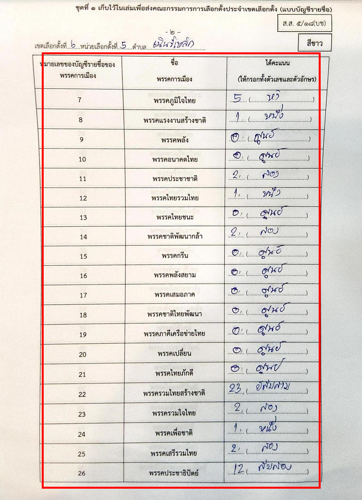

In [120]:
image  = Image.open(image_path)
imdraw = ImageDraw.Draw(image)
colours = [(255,0,0),
           (0,255,0),
           (0,0,255),
           (200,0,200)]

for i, rect in enumerate(result.pred_instances.bboxes[:1].tolist()):
    imdraw.rectangle(rect, outline=colours[i%len(colours)], width=5)

resize_image(image, 500)

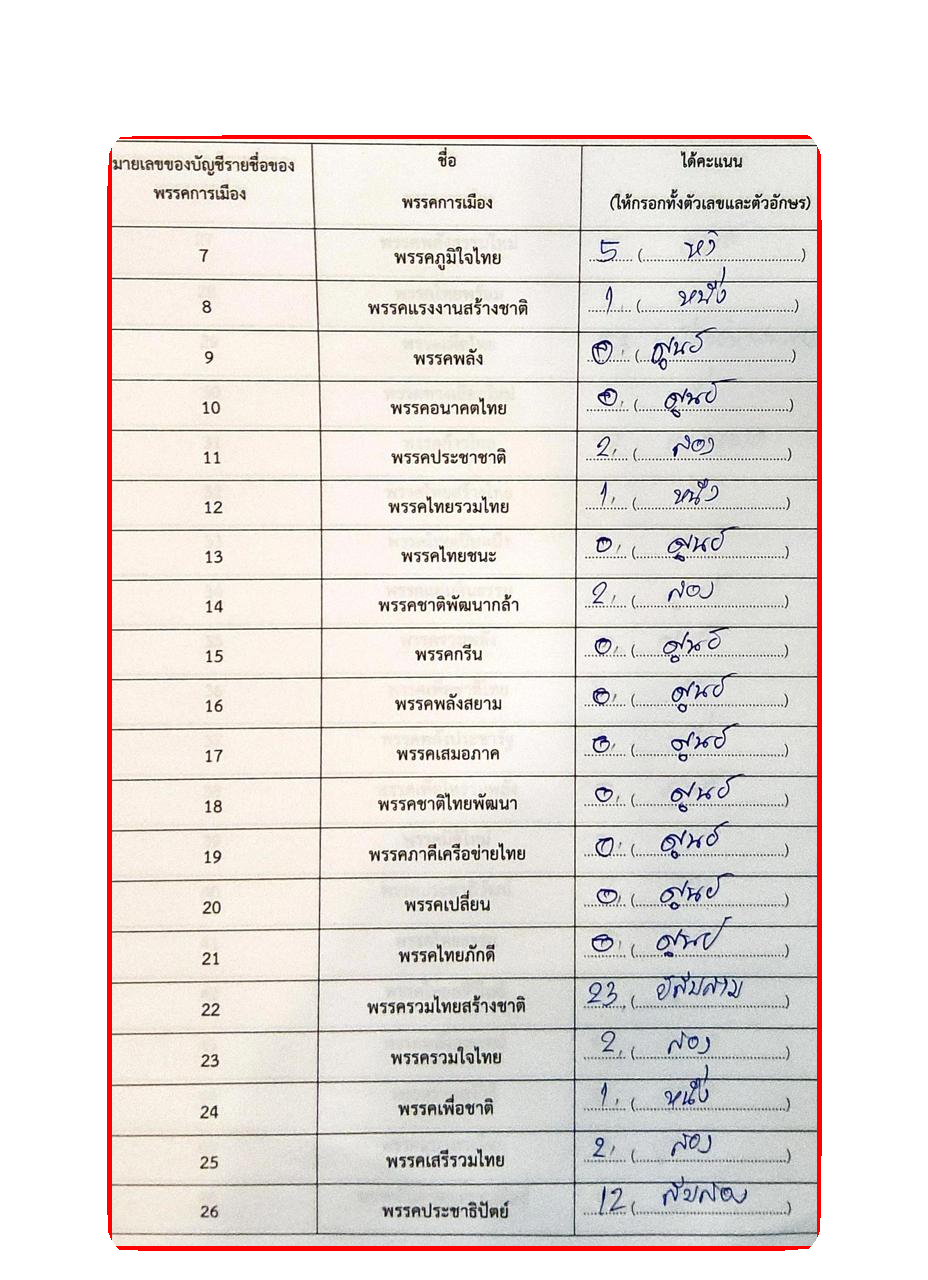

In [121]:
test_im = image.copy()
test_im.paste(mask, (0,0), mask)
test_im